In [1]:
import pandas as pd
all_data = pd.read_pickle('all_data.pkl')

In [2]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import re

Populating the interactive namespace from numpy and matplotlib


### Data Cleaning

In [3]:
all_data.columns

Index(['year', 'name', 'position', 'ht', 'wt', 'fourty', 'vert', 'bench',
       'broad', 'three_cone', 'shuttle'],
      dtype='object')

In [4]:
#columns_to_drop = ['three_cone']
#all_data = all_data.drop(columns_to_drop, axis=1)

all_data = all_data.dropna().reset_index(drop=True)

In [5]:
#Convert height to inches
def fix_ht(row):
    ht = row['ht']
    ht = ht.split('-')
    ht_inches = (int(ht[0])*12 + int(ht[1]))
    return ht_inches

all_data['ht'] = all_data.apply(fix_ht, axis=1)

In [6]:
#Chagne data types of numeric columns
numeric_cols_ = ['year', 'ht', 'wt', 'fourty', 'vert', 'bench', 'broad', 'shuttle', 'three_cone']
all_data[numeric_cols_] = all_data[numeric_cols_].apply(pd.to_numeric)

In [7]:
all_data['position'].unique()

array(['OT', 'OLB', 'CB', 'S', 'OG', 'ILB', 'DE', 'DT', 'RB', 'TE', 'FB',
       'C', 'WR', 'QB', 'LS', 'EDGE', 'LB', 'OL', 'DL', 'DB', 'T', 'NT'],
      dtype=object)

In [8]:
# Grouping positions that are synonomous or similar
position_groupings = {
    'OL' : ['OT', 'OG', 'C', 'OL', 'T'],
    'DL' : ['DT', 'NT', 'DL'],
    'DE' : ['DE', 'EDGE'],
    'LB' : ['OLB', 'ILB', 'LB'],
    'DB' : ['CB', 'S', 'DB']
}

In [9]:
def fix_positions(row):
    '''Using position groupings to create desired position groups.'''
    position = row['position']
    
    for k in position_groupings.keys():
        if position in position_groupings[k]:
            position = k
    return position

all_data['position'] = all_data.apply(fix_positions, axis = 1)

#all_data['position'].value_counts()

In [10]:
#Make sure no duplicates
# all_data[all_data.duplicated()]

### Feature Engineering

In [11]:
def add_deviation_feature(df, feature, category):
    '''standardize a feature for a group (categorical variable)'''
    
    # temp groupby object
    category_gb = df.groupby(category)[feature]
    
    # create columns of category means and standard deviations
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (df[feature] - category_mean) / category_std 
    df[feature + '_dev_' + category] = deviation_feature

### Feature Engineering
Trying out some different feature combinations, uncomment if you want to use one.

In [12]:
#Measure of size relative to height
###all_data['bmi'] = (all_data['wt'] / all_data['ht']**2)*703

#How fast/explosive someone is for their size relative to height
###all_data['fourty/bmi'] = all_data['fourty'] / all_data['bmi']
###all_data['vert/bmi'] = all_data['vert'] / all_data['bmi']
###all_data['bench/bmi'] = all_data['bench'] / all_data['bmi']
###all_data['broad/bmi'] = all_data['broad'] / all_data['bmi']
###all_data['shuttle/bmi'] = all_data['shuttle'] / all_data['bmi']

#How fast/explosive someone is for their weight
all_data['fourty/wt'] = all_data['fourty'] / all_data['wt']
###all_data['vert/wt'] = all_data['vert'] / all_data['wt']
###all_data['bench/wt'] = all_data['bench'] / all_data['wt']
###all_data['broad/wt'] = all_data['broad'] / all_data['wt']
###all_data['shuttle/wt'] = all_data['shuttle'] / all_data['wt']

#How fast/explosive someone is for their weight
###all_data['fourty/wt'] = all_data['fourty'] / all_data['wt']
all_data['vert/wt'] = all_data['vert'] / all_data['wt']
all_data['bench/wt'] = all_data['bench'] / all_data['wt']
all_data['broad/wt'] = all_data['broad'] / all_data['wt']
###all_data['shuttle/wt'] = all_data['shuttle'] / all_data['wt']

#Inverse of BMI if we want to think about body type in terms of inches of height per pound
#Sort of like how lanky is someone
all_data['lankiness'] = (all_data['ht'] / all_data['wt'])

#Higher if someone's vert is really good compared to their broad
all_data['vert/broad'] = all_data['vert'] / all_data['broad']
#Or the reverse
all_data['broad/vert'] = all_data['broad'] / all_data['vert']

#Random stuff
###all_data['fourty/vert/ht'] = all_data['fourty'] / all_data['vert'] / all_data['ht']
all_data['broad/ht'] = all_data['broad'] / all_data['ht']
all_data['fourty/lankiness'] = all_data['fourty'] / all_data['lankiness']

In [13]:
#Deviation features

add_deviation_feature(all_data, 'vert/broad', 'position')
add_deviation_feature(all_data, 'lankiness', 'position')
add_deviation_feature(all_data, 'fourty/wt', 'position')
add_deviation_feature(all_data, 'wt', 'position')
add_deviation_feature(all_data, 'fourty', 'position')
add_deviation_feature(all_data, 'ht', 'position')


add_deviation_feature(all_data, 'three_cone', 'position')

In [14]:
#all_data[all_data['position'] == 'DB'].describe()

### Set up a data frame with the positions you want to include

In [15]:
def create_pos_df(pos_to_keep):
    '''
    Pass in a list of positions to keep.
    Returns a data frame including only those positions.
    '''
    
    all_pos = set(all_data['position'].unique())
    keep_pos = set(pos_to_keep)
    drop = all_pos - keep_pos
    
    pos_df = all_data.copy()
    
    for pos in drop:
        pos_df.drop(pos_df.loc[pos_df['position'] == pos].index, inplace=True)
    
    print(pos_df['position'].value_counts())
    
    return pos_df

In [16]:
nonline_def_df = create_pos_df(['DB', 'DE', 'LB'])
ol_df = create_pos_df(['OL'])
db_df = create_pos_df(['DB'])

DB    651
LB    422
DE    309
Name: position, dtype: int64
OL    721
Name: position, dtype: int64
DB    651
Name: position, dtype: int64


### Checking features for colinearity, relationships, clusters, etc.

In [17]:
def feature_plot_check(df, features_to_check, target_column):
    '''
    Pass in data frame, list of columns, and target column as string.
    Returns: Pairplot of features and target (target will be last column) and correl matrix.
    '''
    graph_df = pd.concat([df[features_to_check], df.loc[:, [target_column]]], axis=1)
    
    if 'position' in features_to_check:
        sns.pairplot(graph_df, plot_kws=dict(alpha=.4, edgecolor='none'), hue='position', corner=False)
        plt.show();
    else:
        sns.pairplot(graph_df, plot_kws=dict(alpha=.4, edgecolor='none'), corner=True)
        plt.show();
        
    upper = np.triu(graph_df.corr())
    sns.heatmap(graph_df.corr(), cmap="seismic_r", annot=True, vmin=-1, vmax=1, mask=upper);
    

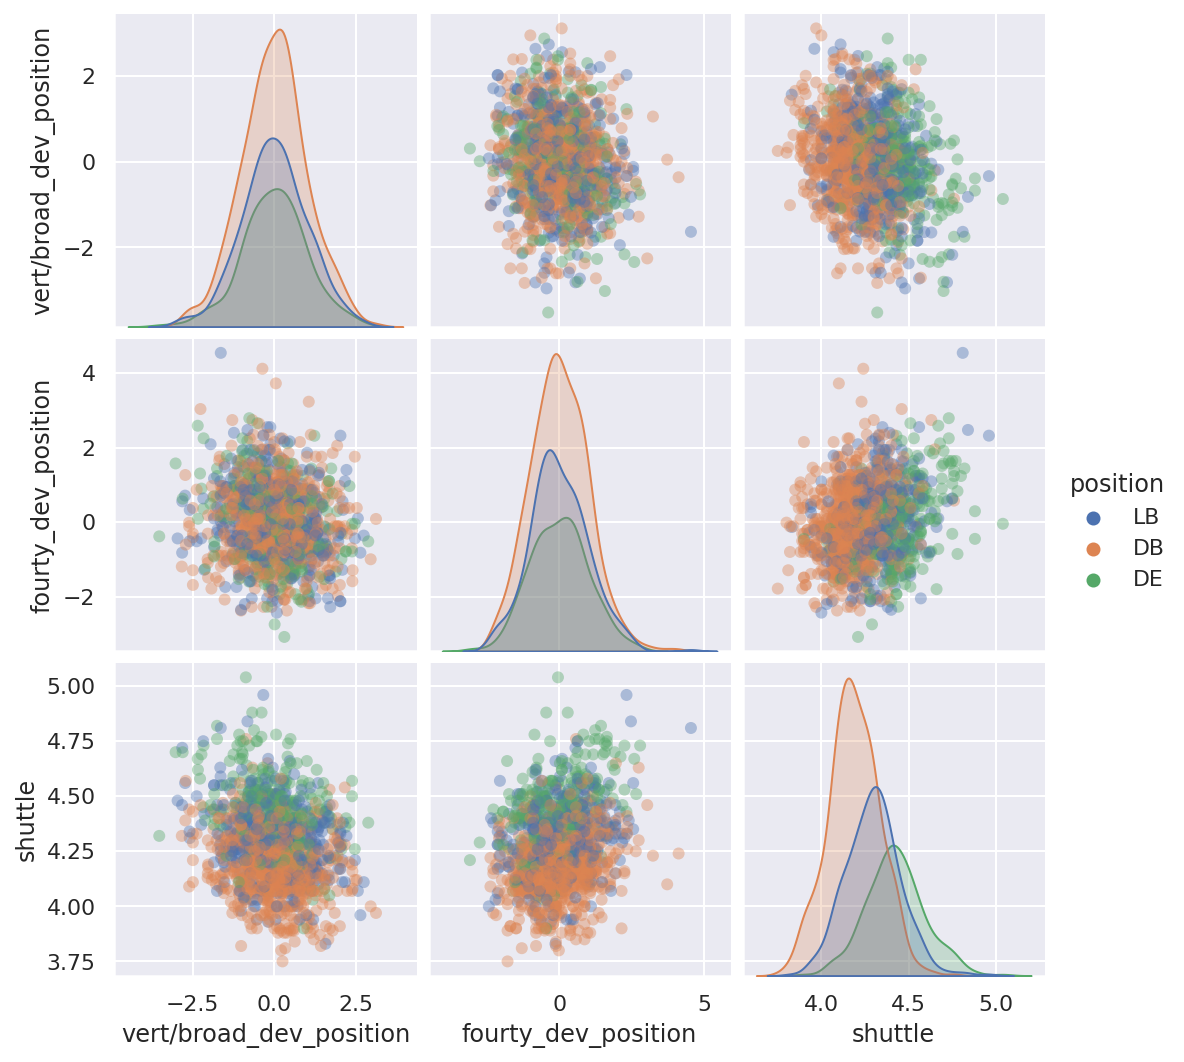

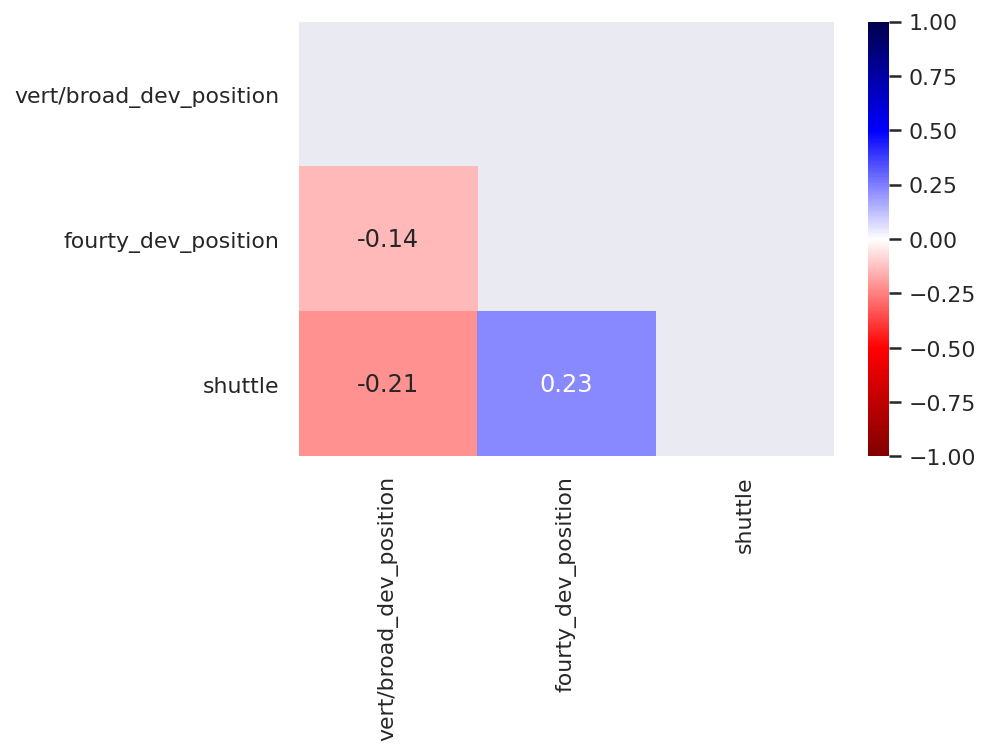

In [18]:
feature_plot_check(nonline_def_df, ['position',
                                    'vert/broad_dev_position',
                                    'fourty_dev_position'], 'shuttle')

### Functions for creating a new model, training, testing, scoring, etc.

In [19]:
def define_model(df, features, target):
    '''    
    Inputs:
    df: Data frame with data (usually going to be the data frame you created with the positions you want 
    in the analysis)
    features: Pass in a list, must be columns in the df
    target: Pass in a string for the title column to be y
    
    Returns: X as Data Frame, y as Series
    '''

    X = df[features]

    y = df.loc[:, [target]] #y as a data frame here so we can concat for the pair plot

    #Concating X and y for the pair plot
    model_data = pd.concat([X, y], axis=1)
    
    y = y.iloc[:,0]
    
    return X, y

---

In [20]:
def adj_r2(X, y, r_sq):
    return 1 - (1-r_sq)*(len(y)-1)/(len(y)-X.shape[1]-1)

In [21]:
def split_and_test(X, y):
    '''
    Splits and cross validates training data and computes and prints several metrics for comparing and 
    evaluating models.
    
    Inputs:
    X: Data Frame
    y: Series
    '''
    
    
    # perform train/val split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    r_sq_score_train = lr_model.score(X_train, y_train)
    adj_r2_train = adj_r2(X_train, y_train, r_sq_score_train)
    
    #Score on cross validation
    lm = LinearRegression()
    cross_val_r2 = cross_val_score(lm, X, y, cv=5, scoring='r2') # scoring metric
    print(f'Cross Validation R Squared: {cross_val_r2}')
    print(f'Cross Validation R Squared Mean: {np.mean(cross_val_r2)}')
    print(f'Cross Validation R Squared Median: {np.median(cross_val_r2)}')
    
    # score fit model on validation data
    r_sq_score_test = lr_model.score(X_test, y_test)
    adj_r2_test = adj_r2(X_test, y_test, r_sq_score_test)

    # report results
    print('\nTrain Data R^2 score was:', r_sq_score_train)
    print('Train Data Adj R^2 score was:', adj_r2_train)
    
    print('\nTest Data R^2 score was:', r_sq_score_test)
    print('Test Data Adj R^2 score was:', adj_r2_test)
    
    
    constant = lr_model.intercept_
    print('Constant: ', constant)
   
    
    print('\nFeature coefficient results: \n')
    
    #Getting coefficient scores
    coef_df = pd.DataFrame(columns=['feature', 'coef'])
    
    for i, feature in enumerate(X.columns):
        coef_df.loc[i, 'feature'] = feature
    
    coefs = lr_model.coef_.tolist()
    #print(coefs)

    for i, coef in enumerate(coefs):
        #print(coef)
        coef_df.loc[i, 'coef'] = coef
    
    return coef_df

In [22]:
def OLS_summary_training_data(X, y):
    '''
    Gives some basic summary statistic information using OLS from stats models.
    
    Inputs:
    X: Data Frame
    y: Series
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)
    
    #Create the model
    model = sm.OLS(y_train, sm.add_constant(X_train)) 

    #Fit
    fit = model.fit()

    #Print out summary
    return fit.summary()

In [23]:
def pred_plot(X, y):
    '''
    Prints model performance metrics and y pred vs y acctual plot.
    
    Inputs:
    X: Data Frame
    y: Series
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)
    lm = LinearRegression()
    lm.fit(X_train, y_train)

    preds_train = lm.predict(X_train) # generate predictions using fit model
    
    print(f' RMSE (Training Data Predictions): {mean_squared_error(y_train, preds_train, squared=False)}')
    print(f' MAE (Training Data Predictions): {mean_absolute_error(y_train, preds_train)}')
    print(f' R squared (Training Data Predictions): {r2_score(y_train, preds_train)}')

    ax_train = sns.jointplot(x=preds_train,y=y_train, kind='reg')
    ax_train.set_axis_labels('Predicted y values (Training Set)',
                       'Acctual y values (Training Set)', fontsize=16)
    plt.show()

    
    preds_test = lm.predict(X_test) # generate predictions using fit model
    
    print(f' RMSE (Test Data Predictions): {mean_squared_error(y_test, preds_test, squared=False)}')
    print(f' MAE (Test Data Predictions): {mean_absolute_error(y_test, preds_test)}')
    print(f' R squared (Test Data Predictions): {r2_score(y_test, preds_test)}')

    ax_test = sns.jointplot(x=preds_test,y=y_test, kind='reg')
    ax_test.set_axis_labels('Predicted y values (Test Set)',
                       'Acctual y values (Test Set)', fontsize=16)
    plt.show()


    return

In [24]:
def lasso(X, y):
    '''
    Runs LassoCV and prints relavent information.
    
    Inputs:
    X: Data Frame
    y: Series
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)
    
    alphavec = 10**np.linspace(-10,2,200)
    lasso_model = LassoCV(alphas = alphavec, cv=5)
    lasso_model.fit(X_train, y_train)
    optimal_alpha = lasso_model.alpha_
    
    print('Alpha:', optimal_alpha)
    print('\nLasso Model Coefficients:')
    print(list(zip(X_train.columns, lasso_model.coef_)))
    
    train_set_pred = lasso_model.predict(X_train)
    
    print('\n MAE on Train Data: ', mean_absolute_error(y_train, train_set_pred))
    print('R Sq on Train Data: ', r2_score(y_train, train_set_pred))
    
    
    
    test_set_pred = lasso_model.predict(X_test)
    
    print('\n MAE on Test Data: ', mean_absolute_error(y_test, test_set_pred))
    print('R Sq on Test Data: ', r2_score(y_test, test_set_pred))
    
    return

    

# Space to create and test new models by specifying features and target

In [25]:
X1, y1 = define_model(nonline_def_df, ['position', 'vert/broad_dev_position'], 'shuttle')
X2, y2 = define_model(nonline_def_df, ['position', 'fourty_dev_position'], 'shuttle')

X3, y3 = define_model(ol_df, ['vert/broad_dev_position'], 'shuttle')
X4, y4 = define_model(ol_df, ['fourty_dev_position'], 'shuttle')

In [26]:
def make_interaction(X, interaction_col):
    Xinter = pd.get_dummies(X, drop_first=True)
    regex_col_tag = re.compile('position_..')
    cols = list(Xinter.columns)
    cat_cols = re.findall(regex_col_tag, ' '.join(cols))

    for column in cat_cols:
        Xinter[column] = Xinter[column] * Xinter[interaction_col]
        
    return Xinter

In [38]:
def run_model(X, y, drop_LB=True):
    '''
    Splits and validates a model & generates summary data on model performance.
    
    Inputs:
    X: Data Frame
    y: Series
    drop_LB (default=True): True for models using all defensive positions. We will drop the pos dummy column for LB.
    '''
    print('FEATURES -----  ', X.columns)
    print('------------------------------------------------------------------------------------')
    if drop_LB:
        print(lasso(pd.get_dummies(X).drop('position_LB', axis=1), y))
        print(split_and_test(pd.get_dummies(X).drop('position_LB', axis=1), y))
        print(pred_plot(pd.get_dummies(X).drop('position_LB', axis=1), y))
    else:
        print(lasso(X, y))
        print(split_and_test(X, y))
        print(pred_plot(X, y))

FEATURES -----   Index(['position', 'vert/broad_dev_position'], dtype='object')
------------------------------------------------------------------------------------
Alpha: 1e-10

Lasso Model Coefficients:
[('vert/broad_dev_position', -0.04001882615330499), ('position_DB', -0.10627131115358386), ('position_DE', 0.13998929887362838)]

 MAE on Train Data:  0.11744231078776356
R Sq on Train Data:  0.33252619940166717

 MAE on Test Data:  0.12608544816088307
R Sq on Test Data:  0.22793641015954957
None
Cross Validation R Squared: [0.25179775 0.29466379 0.30048705 0.36264518 0.20808357]
Cross Validation R Squared Mean: 0.28353546828598514
Cross Validation R Squared Median: 0.29466379139435495

Train Data R^2 score was: 0.33252619940166706
Train Data Adj R^2 score was: 0.3307074696997643

Test Data R^2 score was: 0.22793640983629626
Test Data Adj R^2 score was: 0.21945219455977205
Constant:  4.2903341879388215

Feature coefficient results: 

                   feature       coef
0  vert/broad

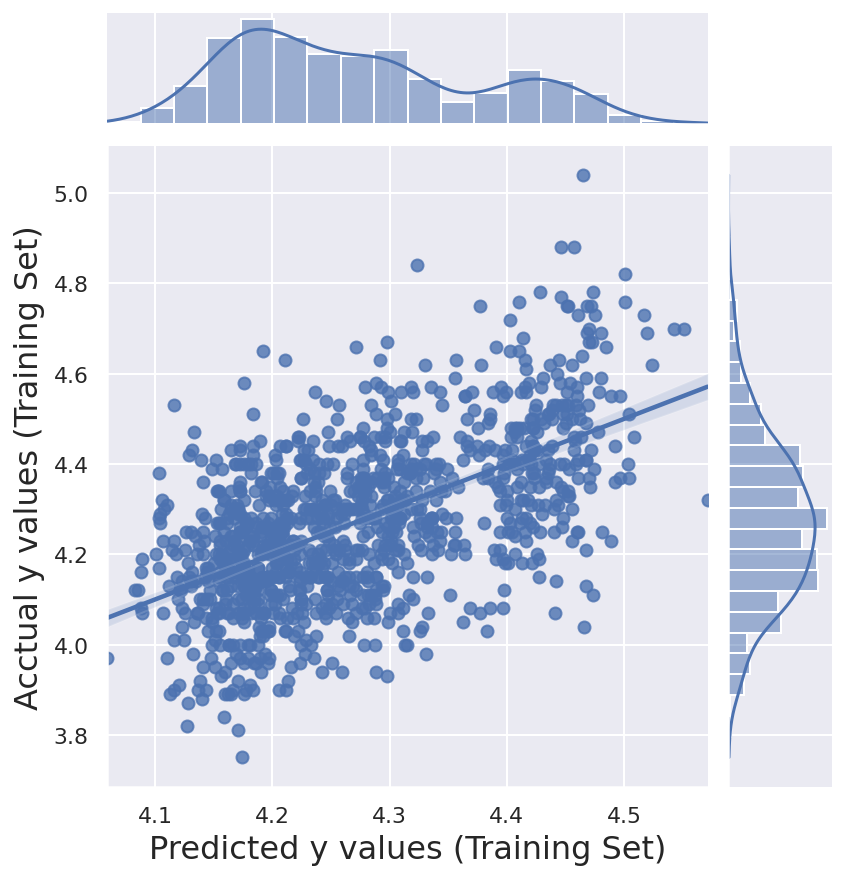

 RMSE (Test Data Predictions): 0.1641713338568629
 MAE (Test Data Predictions): 0.12608544818485573
 R squared (Test Data Predictions): 0.22793640983629626


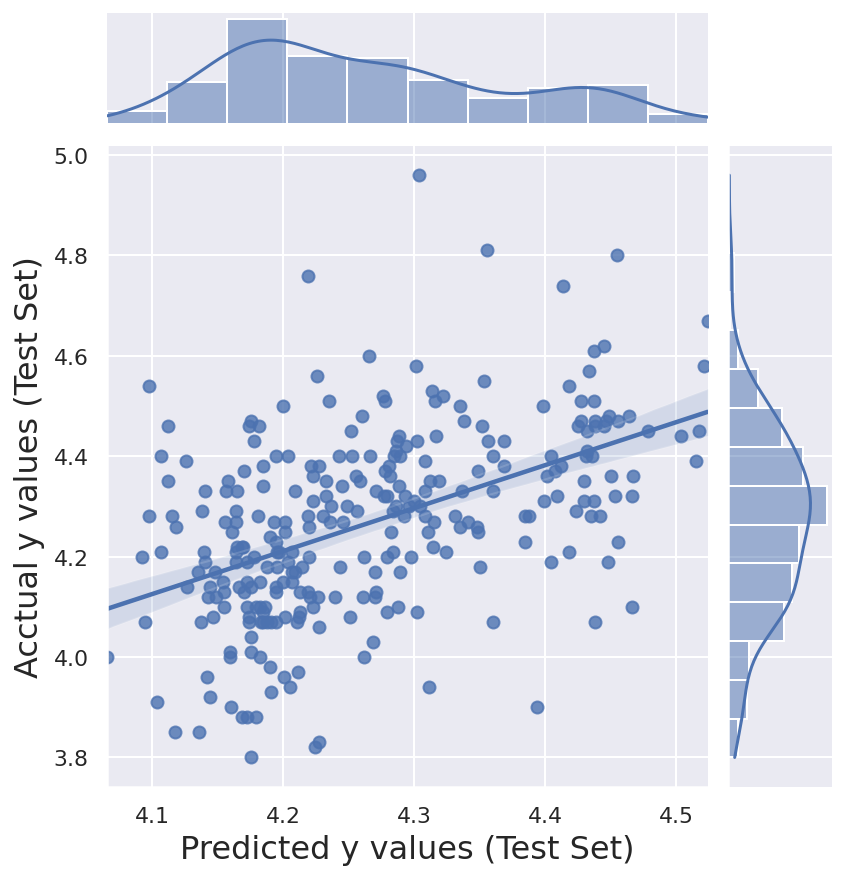

None


In [39]:
run_model(X1, y1)

In [40]:
OLS_summary_training_data(pd.get_dummies(X1).drop('position_LB', axis=1), y1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                shuttle   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     182.8
Date:                Tue, 06 Jul 2021   Prob (F-statistic):           3.43e-96
Time:                        18:30:59   Log-Likelihood:                 544.83
No. Observations:                1105   AIC:                            -1082.
Df Residuals:                    1101   BIC:                            -1062.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       4.2903      0.008    534.326      0.000       4.275       4.306
vert/broad_dev_position    -0.0400      0.004     -8.976      0.000      -0.049      -0.031
position_DB                -0.1063      0.010    -10.267      0.000      -0.127      -0.086
position_DE                 0.1400      0.012     11.362      0.000       0.116       0.164
==============================================================================
Omnibus:                        2.984   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.225   Jarque-Bera (JB):                2.846
Skew:                           0.110   Prob(JB):                        0.241
Kurtosis:                       3.116   Cond. No.                         4.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

FEATURES -----   Index(['position', 'fourty_dev_position'], dtype='object')
------------------------------------------------------------------------------------
Alpha: 1e-10

Lasso Model Coefficients:
[('fourty_dev_position', 0.04166058110006967), ('position_DB', -0.10591572671272702), ('position_DE', 0.13904374690953075)]

 MAE on Train Data:  0.11670688379149731
R Sq on Train Data:  0.3355592904742454

 MAE on Test Data:  0.12447293649410336
R Sq on Test Data:  0.2545693120091205
None
Cross Validation R Squared: [0.23580739 0.23786143 0.33052373 0.39873368 0.24641833]
Cross Validation R Squared Mean: 0.2898689101727413
Cross Validation R Squared Median: 0.24641832522530405

Train Data R^2 score was: 0.3355592904742455
Train Data Adj R^2 score was: 0.33374882532567396

Test Data R^2 score was: 0.2545693117621505
Test Data Adj R^2 score was: 0.24637776573755876
Constant:  4.290067882493572

Feature coefficient results: 

               feature       coef
0  fourty_dev_position  0.04166

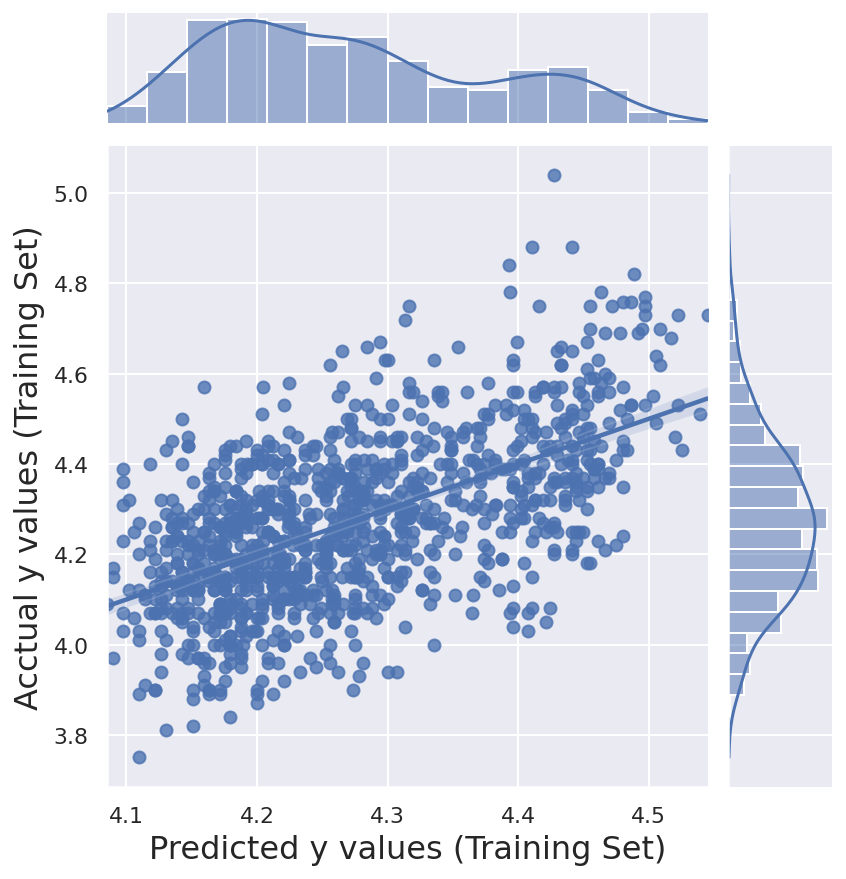

 RMSE (Test Data Predictions): 0.1613148782751168
 MAE (Test Data Predictions): 0.12447293651048766
 R squared (Test Data Predictions): 0.2545693117621505


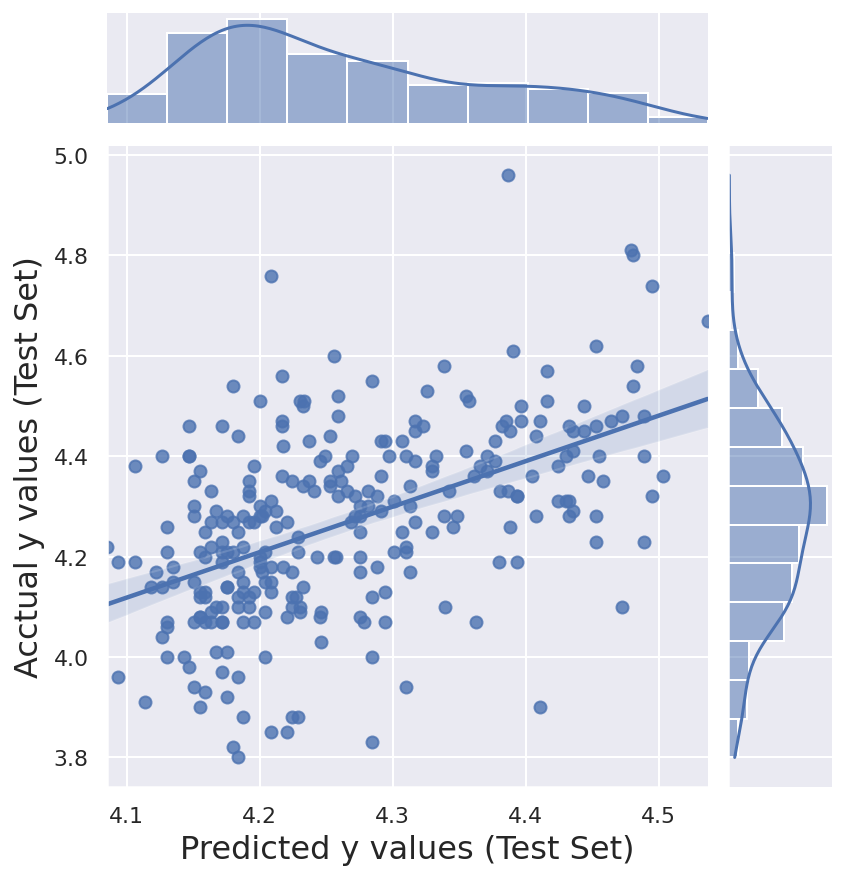

None


In [41]:
run_model(X2, y2)

FEATURES -----   Index(['vert/broad_dev_position'], dtype='object')
------------------------------------------------------------------------------------
Alpha: 0.001135733358343105

Lasso Model Coefficients:
[('vert/broad_dev_position', -0.03955543223346891)]

 MAE on Train Data:  0.15596778439779635
R Sq on Train Data:  0.04157385934105273

 MAE on Test Data:  0.14412295711159795
R Sq on Test Data:  0.012752603301057763
None
Cross Validation R Squared: [ 0.0512542  -0.04819456 -0.09575441  0.03595461  0.00935296]
Cross Validation R Squared Mean: -0.009477439209050642
Cross Validation R Squared Median: 0.009352963956059002

Train Data R^2 score was: 0.04160484313293045
Train Data Adj R^2 score was: 0.039935165159294406

Test Data R^2 score was: 0.012008354209320782
Test Data Adj R^2 score was: 0.0050993217212741415
Constant:  4.747059078478506

Feature coefficient results: 

                   feature       coef
0  vert/broad_dev_position -0.0406652
 RMSE (Training Data Predictions): 0

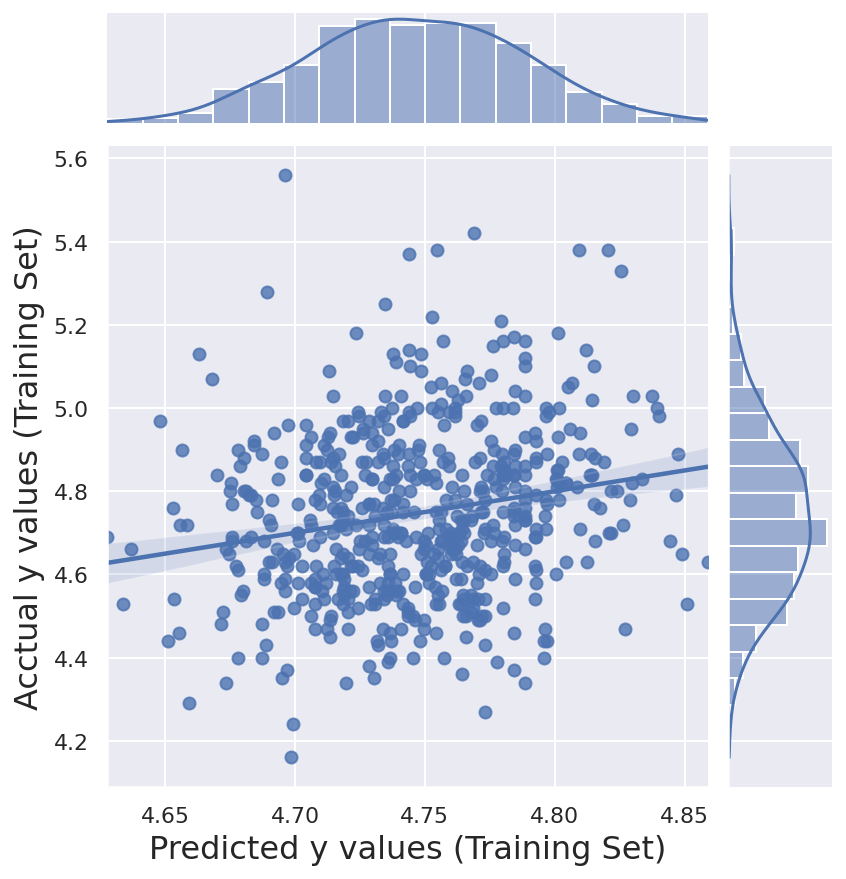

 RMSE (Test Data Predictions): 0.17813097748434564
 MAE (Test Data Predictions): 0.14424560724358898
 R squared (Test Data Predictions): 0.012008354209320782


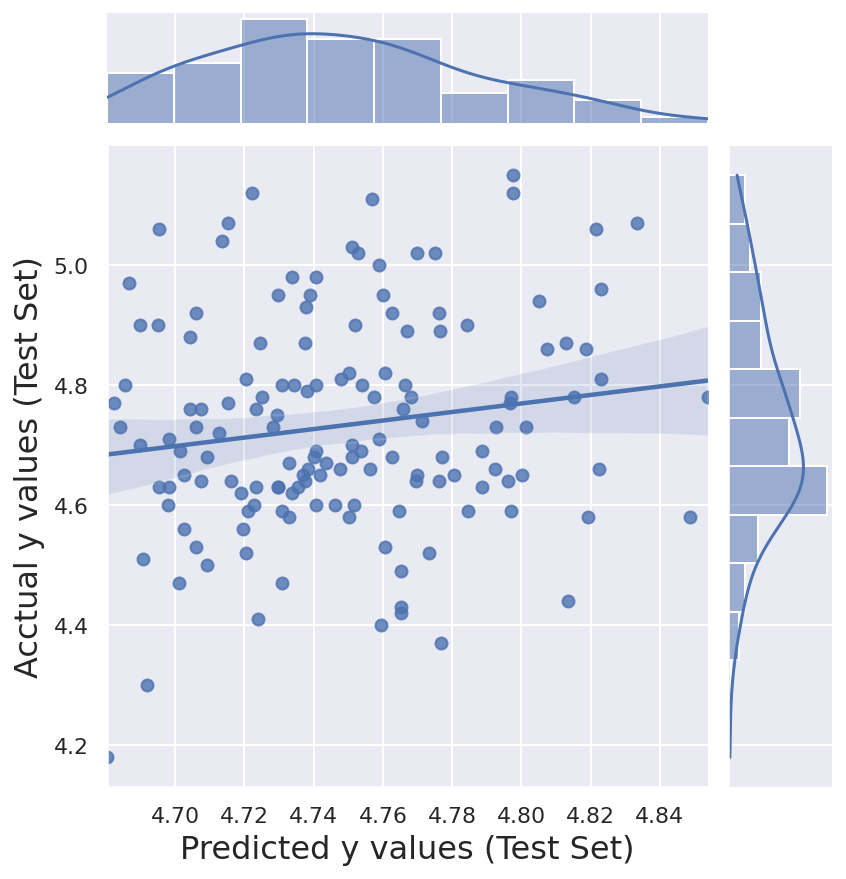

None


In [42]:
run_model(X3, y3, drop_LB=False)

FEATURES -----   Index(['fourty_dev_position'], dtype='object')
------------------------------------------------------------------------------------
Alpha: 5.353566677410719e-05

Lasso Model Coefficients:
[('fourty_dev_position', 0.10330704461694434)]

 MAE on Train Data:  0.13553729418613492
R Sq on Train Data:  0.2641097945536973

 MAE on Test Data:  0.13533562978343877
R Sq on Test Data:  0.07095710959986434
None
Cross Validation R Squared: [0.20251373 0.10417171 0.19024973 0.24049104 0.19705966]
Cross Validation R Squared Mean: 0.18689717212876905
Cross Validation R Squared Median: 0.19705965569231831

Train Data R^2 score was: 0.26410986461687247
Train Data Adj R^2 score was: 0.2628278260534872

Test Data R^2 score was: 0.07082993594810993
Test Data Adj R^2 score was: 0.0643322431925023
Constant:  4.748988714257334

Feature coefficient results: 

               feature     coef
0  fourty_dev_position  0.10336
 RMSE (Training Data Predictions): 0.17301602484654185
 MAE (Training Da

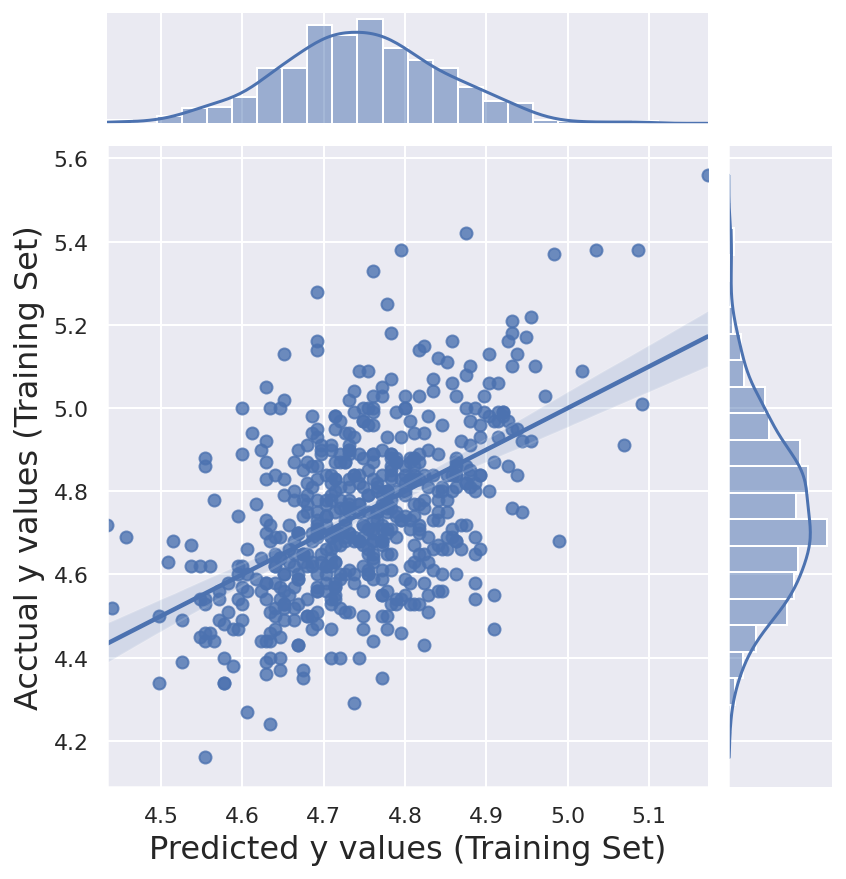

 RMSE (Test Data Predictions): 0.17274696244905233
 MAE (Test Data Predictions): 0.1353428319852622
 R squared (Test Data Predictions): 0.07082993594810993


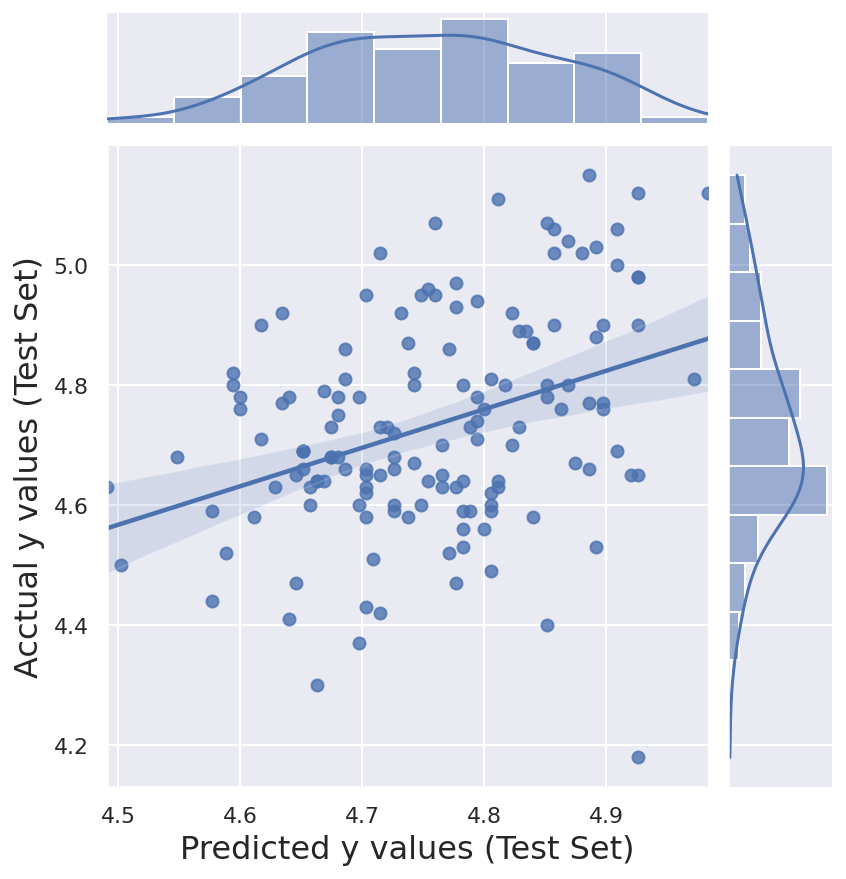

None


In [43]:
run_model(X4, y4, drop_LB=False)